In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

from math import sqrt


In [30]:
df = pd.read_csv('../data/us_disaster_declarations.csv')

In [31]:
# List of mainland U.S. states
mainland_states = [
    "AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA", 
    "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
    "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
    "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
    "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"
]

# Filter rows where the 'state' column is in mainland_states
df = df[df['state'].isin(mainland_states)]

In [32]:
# List of columns to drop
columns_to_drop = [
    "fema_declaration_string", "fips", "place_code", "hash", "id", "last_refresh", 
    "last_ia_filing_date", "fy_declared", "ih_program_declared", "ia_program_declared", 
    "declaration_type", "pa_program_declared", "hm_program_declared", 
    "disaster_closeout_date", "declaration_request_number"  # Removed trailing space
]

# Ensure no trailing/leading spaces in column names
df.columns = df.columns.str.strip()

# Drop columns that exist in the DataFrame
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], axis=1)

# Display remaining columns for verification
print("Remaining columns:", df.columns)



Remaining columns: Index(['disaster_number', 'state', 'declaration_date', 'incident_type',
       'declaration_title', 'incident_begin_date', 'incident_end_date',
       'designated_area'],
      dtype='object')


In [33]:
# Display the count of missing values for each column
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values)

# Calculate the percentage of missing values
missing_percentage = (df.isnull().sum() / len(df)) * 100
print("\nPercentage of missing values per column:\n", missing_percentage)


Missing values per column:
 disaster_number           0
state                     0
declaration_date          0
incident_type             0
declaration_title         0
incident_begin_date       0
incident_end_date      8225
designated_area           0
dtype: int64

Percentage of missing values per column:
 disaster_number         0.000000
state                   0.000000
declaration_date        0.000000
incident_type           0.000000
declaration_title       0.000000
incident_begin_date     0.000000
incident_end_date      13.317897
designated_area         0.000000
dtype: float64


In [34]:
# Drop columns with more than 50% missing values (adjust threshold as needed)
threshold = 0.5
df = df.drop(columns=missing_values[missing_values > len(df) * threshold].index)

# Drop rows with any missing values
df = df.dropna()


In [35]:
# Convert incident_begin_date to datetime (if not already done)
df['incident_begin_date'] = pd.to_datetime(df['incident_begin_date'])

# Sort data by date
df = df.sort_values('incident_begin_date')

# Set incident_begin_date as the index
df.set_index('incident_begin_date', inplace=True)


In [36]:
# Aggregate data to monthly disaster counts
monthly_disasters = df.resample('M').size()

# Aggregate data to annual disaster counts
annual_disasters = df.resample('Y').size()

/tmp/ipykernel_22919/737010312.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_disasters = df.resample('M').size()
/tmp/ipykernel_22919/737010312.py:5: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_disasters = df.resample('Y').size()


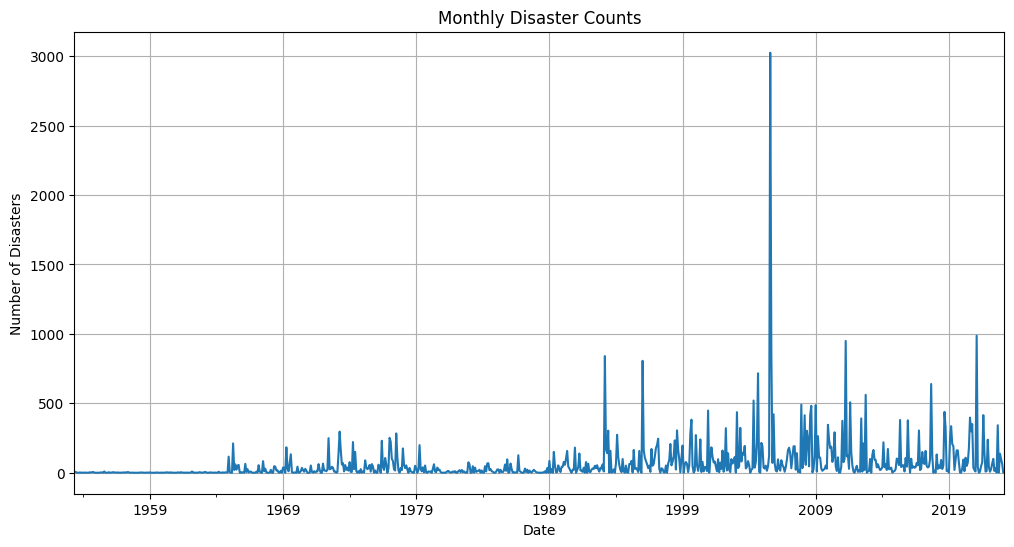

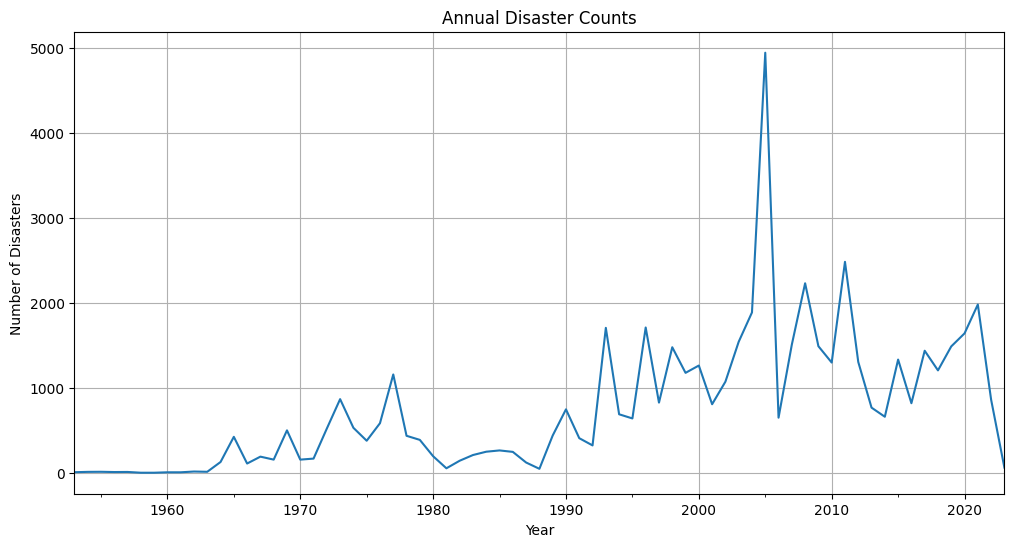

In [37]:
import matplotlib.pyplot as plt

# Plot monthly disaster counts
plt.figure(figsize=(12, 6))
monthly_disasters.plot(title='Monthly Disaster Counts', xlabel='Date', ylabel='Number of Disasters')
plt.grid()
plt.show()

# Plot annual disaster counts
plt.figure(figsize=(12, 6))
annual_disasters.plot(title='Annual Disaster Counts', xlabel='Year', ylabel='Number of Disasters')
plt.grid()
plt.show()

/tmp/ipykernel_22919/3652147798.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  disaster_types = df.groupby('incident_type').resample('Y').size().unstack(level=0)


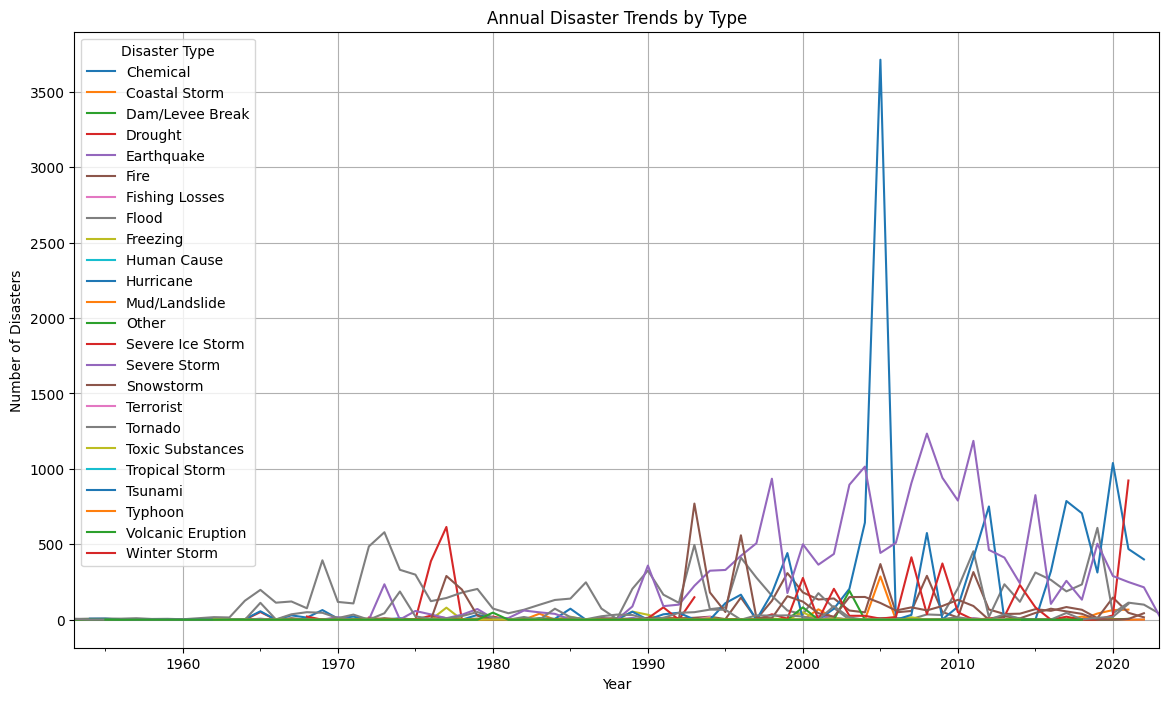

In [38]:
# Aggregate by incident_type and resample by year
disaster_types = df.groupby('incident_type').resample('Y').size().unstack(level=0)

# Plot trends for each type of disaster
disaster_types.plot(figsize=(14, 8), title='Annual Disaster Trends by Type')
plt.xlabel('Year')
plt.ylabel('Number of Disasters')
plt.legend(title='Disaster Type')
plt.grid()
plt.show()


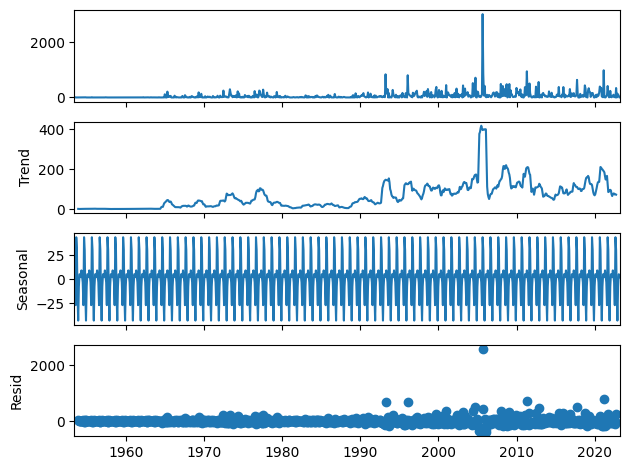

In [39]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose monthly disaster counts
decompose_result = seasonal_decompose(monthly_disasters, model='additive', period=12)

# Plot the decomposition
decompose_result.plot()
plt.show()


In [40]:
# Split into training and testing datasets
split_date = '2019-01-01'  # Adjust as needed
train = monthly_disasters[:split_date]
test = monthly_disasters[split_date:]

# Verify the split
print("Training data range:", train.index.min(), "to", train.index.max())
print("Testing data range:", test.index.min(), "to", test.index.max())


Training data range: 1953-05-31 00:00:00+00:00 to 2018-12-31 00:00:00+00:00
Testing data range: 2019-01-31 00:00:00+00:00 to 2023-03-31 00:00:00+00:00


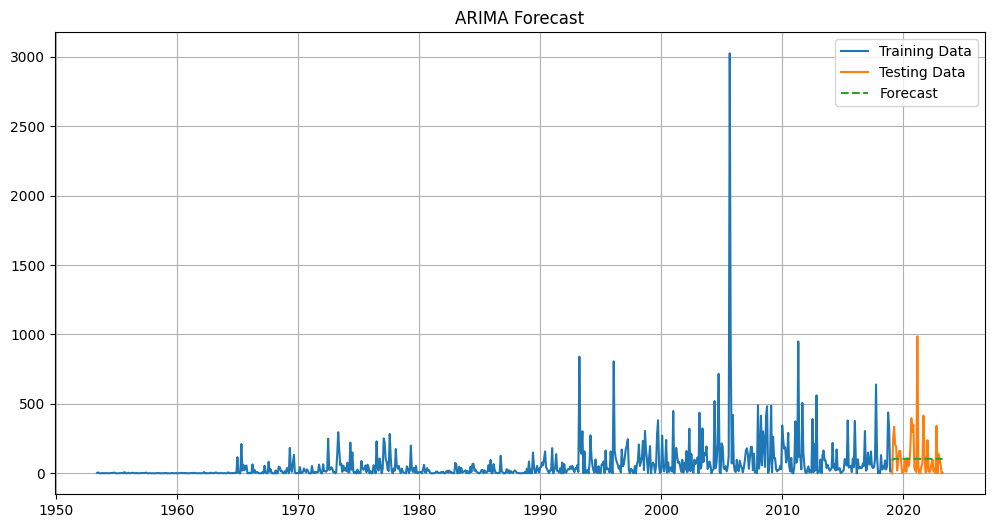

In [41]:
from statsmodels.tsa.arima.model import ARIMA

# Fit an ARIMA model (adjust p, d, q parameters as needed)
arima_model = ARIMA(train, order=(1, 1, 1))  # Example order
arima_result = arima_model.fit()

# Make predictions
forecast = arima_result.forecast(steps=len(test))

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Testing Data')
plt.plot(test.index, forecast, label='Forecast', linestyle='--')
plt.title('ARIMA Forecast')
plt.legend()
plt.grid()
plt.show()


In [45]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test, forecast))
print(f"Root Mean Squared Error: {rmse}")


Root Mean Squared Error: 168.21040075149546


In [46]:
import pandas as pd

# Ensure 'incident_begin_date' is a datetime index
df.reset_index(inplace=True)  # If 'incident_begin_date' is currently the index
df['incident_begin_date'] = pd.to_datetime(df['incident_begin_date'])
df.set_index('incident_begin_date', inplace=True)

# Define the date range from the earliest to the latest date in your dataset
start_date = df.index.min()
end_date = df.index.max()

# Create a complete date range at your desired frequency (e.g., daily)
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Create a DataFrame with this date range
full_df = pd.DataFrame(index=date_range)

# Aggregate your existing data to count the number of disasters per day
daily_disasters = df.resample('D').size()

# Add the disaster counts to the full date range DataFrame
full_df['disaster_count'] = daily_disasters

# Fill NaN values with 0, indicating no disasters occurred on those days
full_df['disaster_count'].fillna(0, inplace=True)

# View the first few rows
print(full_df.head())


                           disaster_count
1953-05-02 00:00:00+00:00               1
1953-05-03 00:00:00+00:00               0
1953-05-04 00:00:00+00:00               0
1953-05-05 00:00:00+00:00               0
1953-05-06 00:00:00+00:00               0


/tmp/ipykernel_22919/372210231.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  full_df['disaster_count'].fillna(0, inplace=True)


In [47]:
# Add a 'no_disaster' feature: 1 if no disaster occurred, 0 if at least one disaster occurred
full_df['no_disaster'] = full_df['disaster_count'].apply(lambda x: 1 if x == 0 else 0)

# View the updated DataFrame
print(full_df.head())


                           disaster_count  no_disaster
1953-05-02 00:00:00+00:00               1            0
1953-05-03 00:00:00+00:00               0            1
1953-05-04 00:00:00+00:00               0            1
1953-05-05 00:00:00+00:00               0            1
1953-05-06 00:00:00+00:00               0            1


In [51]:
# Initialize an empty DataFrame
full_state_df = pd.DataFrame()

for state in states:
    # Get date range for the state
    state_dates = df.loc[state].index
    state_start = state_dates.min()
    state_end = state_dates.max()
    state_date_range = pd.date_range(start=state_start, end=state_end, freq='D')
    
    # Create DataFrame for the state
    state_df = pd.DataFrame(index=state_date_range)
    state_df['state'] = state
    
    # Use MultiIndex for state and date
    state_df.index.name = 'date'
    state_df.reset_index(inplace=True)
    state_df.set_index(['state', 'date'], inplace=True)
    
    # Get daily disaster counts for the state
    state_disasters = df.loc[state].resample('D').size()
    
    # Merge counts into state DataFrame
    state_df['disaster_count'] = state_disasters
    state_df['disaster_count'].fillna(0, inplace=True)
    
    # Add 'no_disaster' feature
    state_df['no_disaster'] = state_df['disaster_count'].apply(lambda x: 1 if x == 0 else 0)
    
    # Concatenate state_df to full_state_df
    full_state_df = pd.concat([full_state_df, state_df])

# Reset index for clarity
full_state_df.reset_index(inplace=True)

# View the DataFrame
print(full_state_df.head())


/tmp/ipykernel_22919/1486412677.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  state_df['disaster_count'].fillna(0, inplace=True)


/tmp/ipykernel_22919/1486412677.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  state_df['disaster_count'].fillna(0, inplace=True)
/tmp/ipykernel_22919/1486412677.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

  state                      date  disaster_count  no_disaster
0    GA 1953-05-02 00:00:00+00:00             0.0            1
1    GA 1953-05-03 00:00:00+00:00             0.0            1
2    GA 1953-05-04 00:00:00+00:00             0.0            1
3    GA 1953-05-05 00:00:00+00:00             0.0            1
4    GA 1953-05-06 00:00:00+00:00             0.0            1


/tmp/ipykernel_22919/1486412677.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  state_df['disaster_count'].fillna(0, inplace=True)
/tmp/ipykernel_22919/1486412677.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

/home/vscode/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/vscode/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


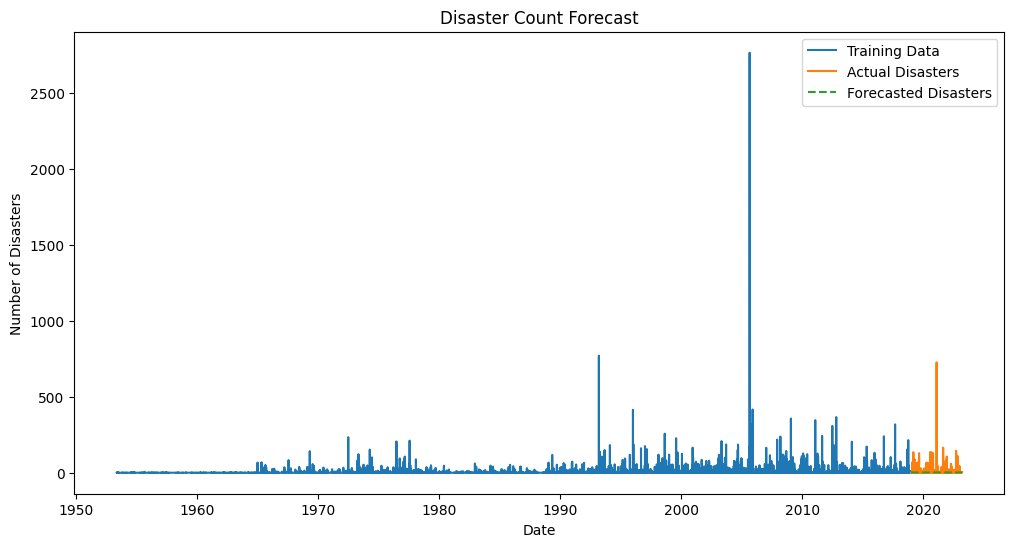

In [52]:
# Use full_df or full_state_df for modeling
# For example, forecasting the number of disasters
from statsmodels.tsa.arima.model import ARIMA

# Split data into training and testing
split_date = '2019-01-01'
train = full_df[:split_date]['disaster_count']
test = full_df[split_date:]['disaster_count']

# Fit ARIMA model (adjust the order as needed)
model = ARIMA(train, order=(1, 0, 1))
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=len(test))

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual Disasters')
plt.plot(test.index, forecast, label='Forecasted Disasters', linestyle='--')
plt.title('Disaster Count Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Disasters')
plt.legend()
plt.show()
